# Build binary classification models where some use RFE selected features

In [27]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score, classification_report
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
xgb.set_config(verbosity=0)
from sklearn.feature_selection import RFECV
import random
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import balanced_accuracy_score
from sklearn import metrics
import matplotlib
from sklearn.model_selection import train_test_split 
pd.set_option('display.max_columns', None)

In [28]:
# First part is merging all meetings
datasets = "Bed002 Bed003 Bed004 Bed005 Bed006 Bed008 Bed009 Bed010 Bed011 Bed012 Bed013 Bed014 Bed015 Bed016 Bed017 Bmr001 Bmr002 Bmr005 Bmr007 Bmr009 Bmr010 Bmr011 Bmr012 Bmr013 Bmr014 Bmr018 Bmr019 Bmr021 Bmr022 Bmr024 Bmr025 Bmr026 Bmr027 Bmr029 Bns001 Bns002".split(" ")
meetings = "Bed002".split(" ")
results_merged_path = "../results_merged/"

all_df = pd.DataFrame()
for elem in meetings:
    path = (os.path.realpath(os.path.join(os.getcwd(), (f"{results_merged_path}"+ elem + ".csv"))))
    df = pd.read_csv(path, sep=';')
    all_df = pd.concat([all_df,df], ignore_index=True)

In [29]:
#change boolean to 1 or 0
all_df['speakerChange'] = all_df["speakerChange"].astype(float)
all_df['boundary'] = all_df["boundary"].astype(float)

#replace nan by zero
all_df.fillna(0,inplace=True)

#keep only useful columns (can't use f0_means, f0_stds, and similarity yet as they are lists)
#test using the same amount of rows with boundary==1 and ==0
nbr_1 = len(all_df.loc[all_df['boundary']==1])
df_0 = all_df.loc[all_df['boundary']==0].head(nbr_1)
df_1 = all_df.loc[all_df['boundary']==1]
df_balanced = pd.concat([df_0,df_1], ignore_index=True)
df_balanced.reset_index(drop=True,inplace=True)
X_df = df_balanced[['StartTimeA','EndTimeA','StartTimeB','EndTimeB','pause','speakerChange']]
y_df = df_balanced['boundary']

#normal split (but WARNING!!! NBR OF BOUNDARY == 1 IS VERYYYY LOW)
X_df = all_df[['StartTimeA','EndTimeA','StartTimeB','EndTimeB','pause','speakerChange']]
y_df = all_df['boundary']

#check dataset statistics
print(y_df.describe())
print(X_df.corrwith(y_df))

#split dataset
X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(X_df, y_df, test_size = 0.20, random_state = 97,stratify=y_df)
X_train_40, X_test_40, y_train_40, y_test_40 = train_test_split(X_df, y_df, test_size = 0.40, random_state = 97,stratify=y_df)

count    916.000000
mean       0.500000
std        0.500273
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
Name: boundary, dtype: float64
StartTimeA       0.549669
EndTimeA         0.548107
StartTimeB       0.549596
EndTimeB         0.549842
pause            0.065347
speakerChange    0.376063
dtype: float64


## Test on commonly used models

### XGB Classifier for binary class

In [30]:
def XGB_class(X_train, X_test, y_train, y_test,learning_rate, n_estimators, max_depth,min_child_weight, gamma, subsample, colsample_bytree, simple):
    
    if simple:
        clf = xgb.XGBClassifier(seed = 24, use_label_encoder =False)
    else:
        clf = xgb.XGBClassifier(learning_rate = learning_rate, n_estimators = int(n_estimators), max_depth = int(max_depth), 
                                min_child_weight = min_child_weight, gamma = gamma, subsample = subsample, 
                                colsample_bytree = colsample_bytree, seed = 24,eval_metric='mlogloss',use_label_encoder =False)

    clf.fit(X_train, y_train)
    y_predicted = clf.predict(X_test)

    print(classification_report(y_test, y_predicted))
    print("Accuracy:", accuracy_score(y_test, y_predicted))
    print("MCC =",matthews_corrcoef(y_test, y_predicted))
    print("AUC =",metrics.roc_auc_score(y_test, y_predicted))
    
    return clf.predict_proba(X_test)[:,1]

In [31]:
XGBc_y_predicted_20 = XGB_class(X_train_20,X_test_20,y_train_20,y_test_20,0,0,0,0,0,0,0,simple=True)
XGBc_y_predicted_40 = XGB_class(X_train_40,X_test_40,y_train_40,y_test_40,0,0,0,0,0,0,0,simple=True)

C:\Users\marti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\marti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87        92
         1.0       0.89      0.84      0.86        92

    accuracy                           0.86       184
   macro avg       0.87      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184

Accuracy: 0.8641304347826086
MCC = 0.7293387850622899
AUC = 0.8641304347826086
              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86       184
         1.0       0.87      0.83      0.85       183

    accuracy                           0.85       367
   macro avg       0.85      0.85      0.85       367
weighted avg       0.85      0.85      0.85       367

Accuracy: 0.8528610354223434
MCC = 0.7067267096157344
AUC = 0.8527856973152768


### SVM for binary class

In [32]:
def SVMc(X_train,X_test,y_train,y_test):
    clf = SVC(kernel='linear',probability=True) 
    clf.fit(X_train, y_train) 
    preds = clf.predict(X_test)
    sSVM_y_predicted = clf.predict_proba(X_test)[:,1]
    
    print(classification_report(y_test, preds))
    print("Accuracy:", accuracy_score(y_test, preds))
    print("MCC =",matthews_corrcoef(y_test, preds))
    print("AUC =",metrics.roc_auc_score(y_test, preds))
    
    return sSVM_y_predicted

In [33]:
# print('Using 20% as test subset:')
# SVM_y_predicted_20 = SVMc(X_train_20,X_test_20,y_train_20,y_test_20)
# print('Using 40% as test subset:')
# SVM_y_predicted_40 = SVMc(X_train_40,X_test_40,y_train_40,y_test_40)

### Random Forest classifier for binary class

In [34]:
def RFc(X_train,X_test,y_train,y_test):
    model = RandomForestClassifier().fit(X_train,y_train)
    preds = model.predict(X_test)
    sRFC_y_predicted = model.predict_proba(X_test)[:,1]
    
    print(classification_report(y_test, preds))
    print("Accuracy:", accuracy_score(y_test, preds))
    print("MCC =",matthews_corrcoef(y_test, preds))
    print("AUC =",metrics.roc_auc_score(y_test, preds))
    
    return sRFC_y_predicted

In [35]:
print('Using 20% as test subset:')
RFc_y_predicted_20 = RFc(X_train_20,X_test_20,y_train_20,y_test_20)
print('Using 40% as test subset:')
RFc_y_predicted_40 = RFc(X_train_40,X_test_40,y_train_40,y_test_40)

Using 20% as test subset:
              precision    recall  f1-score   support

         0.0       0.85      0.86      0.85        92
         1.0       0.86      0.85      0.85        92

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184

Accuracy: 0.8532608695652174
MCC = 0.7065634796993502
AUC = 0.8532608695652174
Using 40% as test subset:
              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87       184
         1.0       0.90      0.81      0.85       183

    accuracy                           0.86       367
   macro avg       0.86      0.86      0.86       367
weighted avg       0.86      0.86      0.86       367

Accuracy: 0.8583106267029973
MCC = 0.7200177377406615
AUC = 0.8581759325255406


### Logistic Regressor for binary class

In [36]:
def LR(X_train,X_test,y_train,y_test):
    model = LogisticRegression(random_state=0).fit(X_train,y_train)
    preds = model.predict(X_test)
    sLR_y_predicted = model.predict_proba(X_test)[:,1]
    
    print(classification_report(y_test, preds))
    print("Accuracy:", accuracy_score(y_test, preds))
    print("MCC =",matthews_corrcoef(y_test, preds))
    print("AUC =",metrics.roc_auc_score(y_test, preds))
    
    return sLR_y_predicted

In [37]:
print('Using 20% as test subset:')
LR_y_predicted_20 = LR(X_train_20,X_test_20,y_train_20,y_test_20)
print('Using 40% as test subset:')
LR_y_predicted_40 = LR(X_train_40,X_test_40,y_train_40,y_test_40)

Using 20% as test subset:
              precision    recall  f1-score   support

         0.0       0.81      0.84      0.82        92
         1.0       0.83      0.80      0.82        92

    accuracy                           0.82       184
   macro avg       0.82      0.82      0.82       184
weighted avg       0.82      0.82      0.82       184

Accuracy: 0.8206521739130435
MCC = 0.6416455781041824
AUC = 0.8206521739130435
Using 40% as test subset:
              precision    recall  f1-score   support

         0.0       0.78      0.83      0.80       184
         1.0       0.81      0.77      0.79       183

    accuracy                           0.80       367
   macro avg       0.80      0.80      0.80       367
weighted avg       0.80      0.80      0.80       367

Accuracy: 0.7956403269754768
MCC = 0.5922763311724212
AUC = 0.7955571394630554


C:\Users\marti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Plot AUC-ROC Curve

In [38]:
def roc(y_tests,y_predicted,models_name,title):  
    if len(y_predicted)>2:  
        #there are 4 diff colors in max
        colors = ["red", "blue", "green", "orange"]
            
        for i in range(int(len(y_predicted)/2)):
            fpr, tpr, _ = metrics.roc_curve(y_tests[i],  y_predicted[i])
            #create ROC curve
            plt.plot(fpr, tpr, linestyle='-',color=colors[i])

        counter=0
        for i in range(int(len(y_predicted)/2),int(len(y_predicted))):
            fpr, tpr, _ = metrics.roc_curve(y_tests[i],  y_predicted[i])
            #create ROC curve
            plt.plot(fpr, tpr, linestyle='--',color=colors[counter])
            counter+=1
    
    else:
        for i in range(int(len(y_predicted))):
            fpr, tpr, _ = metrics.roc_curve(y_tests[i],  y_predicted[i])
            #create ROC curve
            plt.plot(fpr, tpr, linestyle='-')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(models_name)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(title)
    plt.show()

C:\Users\marti\AppData\Local\Temp\ipykernel_23828\1674596823.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_tests = np.array([y_test_20,y_test_20,y_test_20,y_test_40,y_test_40,y_test_40])
C:\Users\marti\AppData\Local\Temp\ipykernel_23828\1674596823.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_preds = np.array([XGBc_y_predicted_20,RFc_y_predicted_20,LR_y_predicted_20,XGBc_y_predicted_40,RFc_y_predicted_40,LR_y_predicted_40])


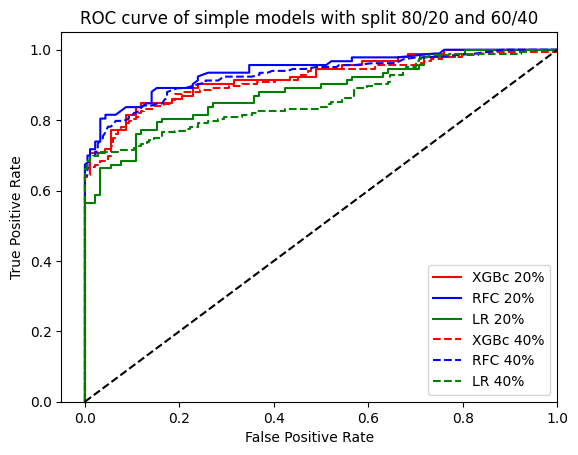

In [39]:
y_tests = np.array([y_test_20,y_test_20,y_test_20,y_test_40,y_test_40,y_test_40])
y_preds = np.array([XGBc_y_predicted_20,RFc_y_predicted_20,LR_y_predicted_20,XGBc_y_predicted_40,RFc_y_predicted_40,LR_y_predicted_40])
models_name=np.array(['XGBc 20%','RFC 20%','LR 20%','XGBc 40%','RFC 40%','LR 40%'])
title = 'ROC curve of simple models with split 80/20 and 60/40'
roc(y_tests,y_preds,models_name,title)